In [2]:
%%bash
wget https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
unzip creditcardfraud.zip

Archive:  creditcardfraud.zip


--2021-07-22 01:50:29--  https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.246.104
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.246.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155632 (66M) [application/zip]
Saving to: ‘creditcardfraud.zip.1’

     0K .......... .......... .......... .......... ..........  0%  689K 98s
    50K .......... .......... .......... .......... ..........  0%  697K 97s
   100K .......... .......... .......... .......... ..........  0%  700K 97s
   150K .......... .......... .......... .......... ..........  0% 35.2M 73s
   200K .......... .......... .......... .......... ..........  0%  697K 78s
   250K .......... .......... .......... .......... ..........  0%  186M 65s
   300K .......... .......... .......... .......... ..........  0%  127M 56s
   350K .......... ..........

CalledProcessError: Command 'b'wget https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip\nunzip creditcardfraud.zip\n'' returned non-zero exit status 1.

In [3]:
import numpy as np 
import pandas as pd

data = pd.read_csv('creditcard.csv', delimiter=',')

In [4]:
print(data.columns)
data[['Time', 'V1', 'V2', 'V27', 'V28', 'Amount', 'Class']].describe()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


In [6]:
feature_columns = data.columns[:-1]
label_column = data.columns[-1]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

Training

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42)

Unsupervised Learning

In [8]:
import boto3
import os
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
bucket = "model-and-data-20210628"
prefix = 'fraud-classifier'

In [9]:
from sagemaker import RandomCutForest

# specify general training job information
rcf = RandomCutForest(role=get_execution_role(),
                      instance_count=1,
                      instance_type='ml.c4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

In [10]:
rcf.fit(rcf.record_set(X_train))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-22 01:52:00 Starting - Starting the training job...
2021-07-22 01:52:02 Starting - Launching requested ML instancesProfilerReport-1626918720: InProgress
......
2021-07-22 01:53:28 Starting - Preparing the instances for training.........
2021-07-22 01:54:48 Downloading - Downloading input data...
2021-07-22 01:55:29 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/22/2021 01:55:32 INFO 139680922376000] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[07/22/2021 01:55:32 INFO 1396809223760


2021-07-22 01:55:52 Uploading - Uploading generated training model
2021-07-22 01:55:52 Completed - Training job completed
Training seconds: 66
Billable seconds: 66


Host Random Cut Forest

In [11]:
rcf_predictor = rcf.deploy(
    endpoint_name='random-cut-forest-endpoint',
    initial_instance_count=1,
    instance_type='ml.c4.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!

In [17]:
from sagemaker.predictor import csv_serializer, json_deserializer


rcf_predictor.serializer = csv_serializer

rcf_predictor.deserializer = json_deserializer

Test Random Cut Forest

In [18]:
def predict_rcf(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        array_preds = [s['score'] for s in current_predictor.predict(array)['scores']]
        predictions.append(array_preds)

    return np.concatenate([np.array(batch) for batch in predictions])

In [19]:
positives = X_test[y_test == 1]
positives_scores = predict_rcf(rcf_predictor, positives)

negatives = X_test[y_test == 0]
negatives_scores = predict_rcf(rcf_predictor, negatives)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_seri

The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_des

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


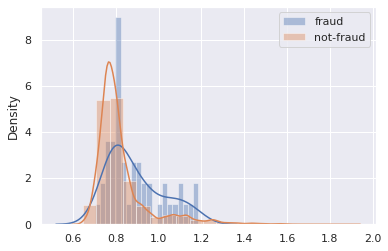

In [21]:
sns.distplot(positives_scores, label='fraud', bins=20)
sns.distplot(negatives_scores, label='not-fraud', bins=20)
plt.legend()

Supervised Learning

In [22]:
import io
import sklearn
from sklearn.datasets import dump_svmlight_file   

buf = io.BytesIO()

sklearn.datasets.dump_svmlight_file(X_train, y_train, buf)
buf.seek(0);

In [23]:
key = 'fraud-dataset'
subdir = 'base'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}/{}'.format(bucket, prefix, subdir, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://model-and-data-20210628/fraud-classifier/train/base/fraud-dataset
Training artifacts will be uploaded to: s3://model-and-data-20210628/fraud-classifier/output


In [24]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='0.90-2')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [25]:
from math import sqrt
from sagemaker import get_execution_role

# Because the data set is so highly skewed, we set the scale position weight conservatively,
# as sqrt(num_nonfraud/num_fraud).
# Other recommendations for the scale_pos_weight are setting it to (num_nonfraud/num_fraud).
scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))
hyperparams = {
    "max_depth":5,
    "subsample":0.8,
    "num_round":100,
    "eta":0.2,
    "gamma":4,
    "min_child_weight":6,
    "silent":0,
    "objective":'binary:logistic',
    "eval_metric":'auc',
    "scale_pos_weight": scale_pos_weight
}

clf = sagemaker.estimator.Estimator(container,
                                    get_execution_role(),
                                    hyperparameters=hyperparams,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)
clf.fit({'train': s3_train_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-07-22 02:21:22 Starting - Starting the training job...
2021-07-22 02:21:46 Starting - Launching requested ML instancesProfilerReport-1626920482: InProgress
...
2021-07-22 02:22:17 Starting - Preparing the instances for training.........
2021-07-22 02:23:53 Downloading - Downloading input data...
2021-07-22 02:24:07 Training - Downloading the training image.....INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[02:24:56] 256326x30 matrix with 7688153 entries loaded from /opt/ml/input/data/train
INFO:root:Single node training.
INFO:root:Train matrix has 256326

Host Classifier

In [ ]:
from sagemaker.predictor import csv_serializer

predictor = clf.deploy(initial_instance_count=1,
                       endpoint_name="fraud-detection-endpoint",
                       instance_type='ml.m4.xlarge', 
                       serializer=csv_serializer,
                       deserializer=None)

# Evaluation

In [26]:
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [27]:
raw_preds = predict(predictor, X_test)

NameError: name 'predictor' is not defined

In [28]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

# scikit-learn expects 0/1 predictions, so we threshold our raw predictions
y_preds = np.where(raw_preds > 0.5, 1, 0)
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, y_preds)))

NameError: name 'raw_preds' is not defined

Keep sending test traffic to the endpoint

In [47]:
from threading import Thread
from generate_endpoint_traffic import generate_traffic

thread = Thread(target = generate_traffic, args=[np.copy(X_test)])
thread.start()

ModuleNotFoundError: No module named 'aws_requests_auth'

SMOTE

In [53]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

ModuleNotFoundError: No module named 'imblearn'

In [54]:
from collections import Counter
print(sorted(Counter(y_smote).items()))

NameError: name 'y_smote' is not defined

In [55]:
smote_buf = io.BytesIO()

# Dump the SMOTE data into a buffer
sklearn.datasets.dump_svmlight_file(X_smote, y_smote, smote_buf)
smote_buf.seek(0);

# Upload from the buffer to S3
key = 'fraud-dataset-smote'
subdir = 'smote'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(smote_buf)

s3_smote_train_data = 's3://{}/{}/train/{}/{}'.format(bucket, prefix, subdir, key)
print('Uploaded training data location: {}'.format(s3_smote_train_data))

smote_output_location = 's3://{}/{}/smote-output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(smote_output_location))

NameError: name 'X_smote' is not defined

In [56]:
try:
    hyperparams.pop("scale_pos_weight") # No need to scale weights after SMOTE resampling, so we remove that parameter
except KeyError:
    # In case the parameter was already removed, do nothing.
    pass
smote_xgb = sagemaker.estimator.Estimator(container,
                                        get_execution_role(),
                                        hyperparameters=hyperparams,
                                        train_instance_count=1, 
                                        train_instance_type='ml.m4.xlarge',
                                        output_path=smote_output_location,
                                        sagemaker_session=session)

NameError: name 'smote_output_location' is not defined

In [57]:
smote_xgb.fit({'train': s3_smote_train_data})

NameError: name 'smote_xgb' is not defined

In [58]:
smote_predictor = smote_xgb.deploy(initial_instance_count=1,
                       endpoint_name="fraud-detection-smote-endpoint",
                       instance_type='ml.m4.xlarge')

# Specify input and output formats.
smote_predictor.content_type = 'text/csv'
smote_predictor.serializer = csv_serializer
smote_predictor.deserializer = None

NameError: name 'smote_xgb' is not defined

In [59]:
smote_raw_preds = predict(smote_predictor, X_test)
smote_preds = np.where(smote_raw_preds > 0.5, 1, 0)

print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, smote_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, smote_preds)))

plot_confusion_matrix(y_test, smote_preds)

print(classification_report(
    y_test, smote_preds, target_names=['non-fraud', 'fraud']))

NameError: name 'smote_predictor' is not defined

In [60]:
for thres in np.linspace(0.1, 0.9, num=9):
    smote_thres_preds = np.where(smote_raw_preds > thres, 1, 0)
    print("Threshold: {:.1f}".format(thres))
    print("Balanced accuracy = {:.3f}".format(balanced_accuracy_score(y_test, smote_thres_preds)))
    print("Cohen's Kappa = {:.3f}\n".format(cohen_kappa_score(y_test, smote_thres_preds)))

NameError: name 'smote_raw_preds' is not defined

In [61]:
# Uncomment to clean up endpoints
# rcf_predictor.delete_endpoint()
# predictor.delete_endpoint()
smote_predictor.delete_endpoint()

NameError: name 'smote_predictor' is not defined